# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Get the data

We have already done the first step -- get the data under the "Get the data" step.
Then, I will follow the recipe to finish the project.

### Have a look at the data
1. Generally view the data
2. Get the info of data
 - Verify the type of the data
 - Check whether there are missing values
3. Obtain the statistical description of the data
 - Total number of examples
 - Analyze the mean of the target which gives hint of imbalanced data
4. Compare the number of data that have target value 0 with data that have target value 1 to detect the imbalanced data
5. Get conclusion (Conclusion is presented at the end of 6.1.1)

In [7]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

In [9]:
data.describe()

,X9,X13,X19,X20,X23,X30,X31,X39,X42,X43,X44,X49,X55,X56,X58,X62,Bankrupt,Id
count,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000
mean,1.579277,0.452284,-0.082028,57.002168,-0.090357,0.691991,-0.068612,0.019158,-0.014902,155.612840,98.610765,-0.072253,1.074023e+04,0.056109,0.959585,177.494445,0.063927,3499.858032
std,1.342723,34.196231,5.754879,182.018911,5.725258,11.217691,5.748967,0.756891,2.617310,795.989622,725.594072,2.638443,8.284685e+04,0.755462,0.932427,2279.713700,0.244648,1392.049260
min,0.000191,-310.340000,-310.800000,-29.340000,-310.890000,-23.060000,-310.800000,-47.047000,-143.520000,-3975.600000,-3946.200000,-144.800000,-1.118500e+06,-46.788000,-0.085920,0.000000,0.000000,1071.000000
25%,1.015600,0.024954,0.004368,18.537750,0.002728,0.085560,0.007006,0.005536,0.000687,76.214500,39.050250,-0.022447,9.771450e+01,0.011478,0.876940,45.065750,0.000000,2296.250000
50%,1.140500,0.067723,0.035307,38.623000,0.030074,0.225955,0.042826,0.040252,0.040963,106.670000,59.014000,0.012481,1.829500e+03,0.053663,0.950825,73.879500,0.000000,3500.500000
75%,1.814050,0.134847,0.088287,66.850750,0.075800,0.406145,0.098331,0.091854,0.090831,149.365000,86.087750,0.060499,7.786950e+03,0.124030,0.990358,118.597500,0.000000,4704.750000
max,37.807000,2340.200000,77.244000,9928.500000,77.244000,656.450000,77.244000,2.901100,40.386000,40515.000000,40515.000000,16.866000,4.212200e+06,1.000000,47.788000,127450.000000,1.000000,5909.000000


In [10]:
data["Bankrupt"].value_counts()

0    4510
1     308
Name: Bankrupt, dtype: int64

Conclusion: From the peek, we can obtain that there are totally 4818 companies among which 4510 of them do not go bankrupt and only 308 of them go bankrupt. That's to say, the data is imbalanced. Additionally, there are 64 attributes and some of them are not numeric. Meanwhile, most of the attributes have missing values. Therefore, firstly, I need to convert all attributes to numeric. Then, I might need to deal with the missing values and imbalanced data in the "cleaning data" step and I also might need to reduce the dimension in the "Transformation" step since the number of attributes is big. 

### Define a performance measure

We would use the accuracy, recall and precision score as performance measure

### Create test set

Since the holdout data do not contain labels, I will seperate the data that contain labels into traning and test set.
1. Convert all attributes to numeric
2. Drop ID column representing the company's identifier, since it has no contribution to the prediction on bankrupt
3. Drop X37 column since there are more than 20% of samples which have null value in X37
4. Drop the rows that have more than 10% missing value
5. Shuffle the data to make the examples in random order so that training set and test set have similar distribution
6. Seperate the dataset into traning set and test set
 - Set 90% of data as training set for training the model
 - Set 10% of data as test set for validation
7. Seperate the features and the target

In [11]:
#Change the data type
cols = data.columns
data[cols] = data[cols].apply(pd.to_numeric,errors='coerce')
#Drop the ID and X37 columns
data = data.drop(columns=["Id","X37"])
#Drop rows having more than 10% null value
for i in range(0,data.shape[0]):
    if data.isna().sum(axis = 1)[i] > 0.1 * data.shape[1]:
        data = data.drop(index = i)
#Shuffle the data
data = sklearn.utils.shuffle(data,random_state=42)
#Seperate the data into training and test set using train_test_split
from sklearn.model_selection import train_test_split
train_data = None
test_data = None
train_data,test_data = train_test_split(data,test_size = 0.1,train_size = 0.9,random_state = 42)
x_train,y_train = train_data.drop(columns = "Bankrupt"),train_data[["Bankrupt"]]
x_test,y_test = test_data.drop(columns = "Bankrupt"),test_data[["Bankrupt"]]
#Flatten y
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

print("Traning set shape: ", train_data.shape)
print("Test set shape: ", test_data.shape)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print(data.info())

Traning set shape:  (4311, 64)
Test set shape:  (479, 64)
x_train shape:  (4311, 63)
y_train shape:  (4311,)
x_test shape:  (479, 63)
y_test shape:  (479,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4790 entries, 562 to 864
Data columns (total 64 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4790 non-null   float64
 1   X2        4790 non-null   float64
 2   X3        4790 non-null   float64
 3   X4        4789 non-null   float64
 4   X5        4781 non-null   float64
 5   X6        4790 non-null   float64
 6   X7        4790 non-null   float64
 7   X8        4790 non-null   float64
 8   X9        4790 non-null   float64
 9   X10       4790 non-null   float64
 10  X11       4790 non-null   float64
 11  X12       4789 non-null   float64
 12  X13       4790 non-null   float64
 13  X14       4790 non-null   float64
 14  X15       4790 non-null   float64
 15  X16       4790 non-null   float64
 16  X17       4790 non-null   flo

## Exploratory Data Analysis

We are going to find the relationship among features and relationship between features and target.
1. View the missing data
2. Impute the data using KNNImputer, since there are many missing values in the features we need to impute the data for analyzing relashionships. I utilize the KNNImputer for consistency.
3. Create the heatmap for analyzing the correlation among features and target
 - Zoom the heatmap to find out the features that have high correlation with target
 - Check the correlation between these features to avoid multicollinearity
4. Create scatter plots for features that have highest correlation with target to further explore relashionships between features and target.
5. Get conclusion(Conclusion is presented at the end of 6.2)

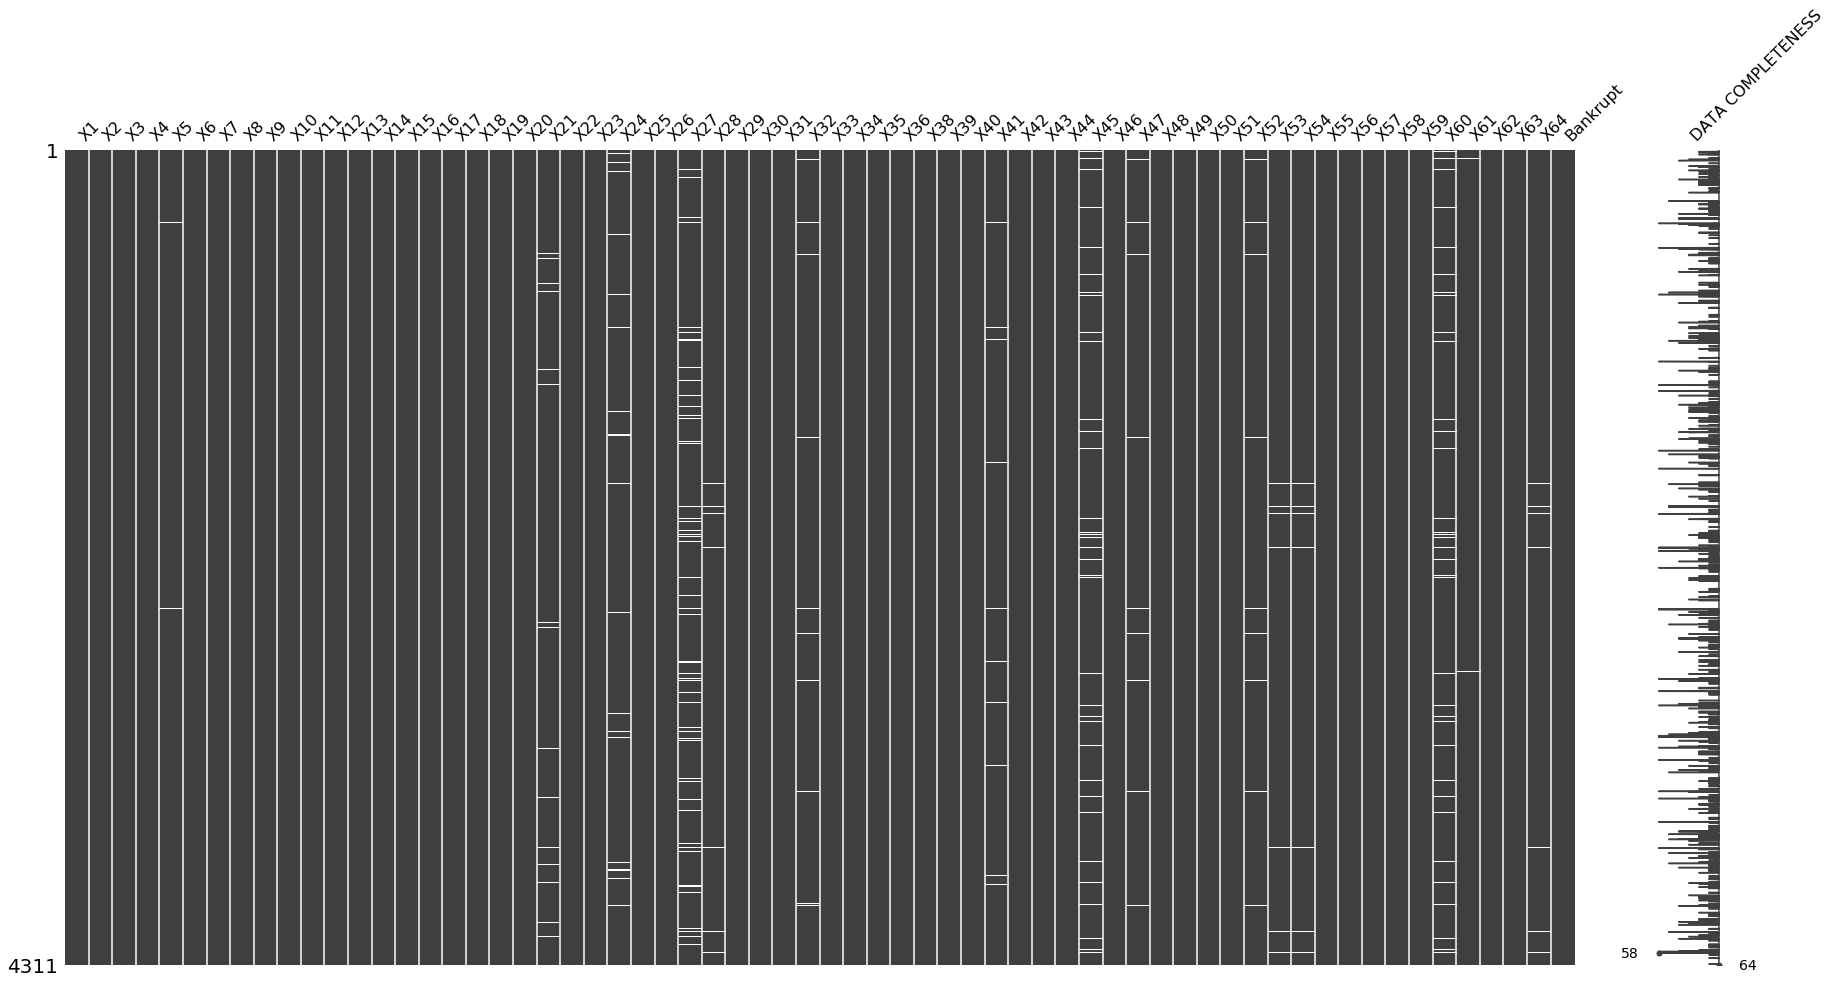

In [12]:
#View where the missing value occur
import missingno as msno
msno.matrix(train_data,figsize=(30,15),labels = True)

In [13]:
#Impute the data
from sklearn.impute import KNNImputer
cols = train_data.columns
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_data_eda = knn_imputer.fit_transform(train_data)
train_data_eda = pd.DataFrame(train_data_eda,columns = cols)

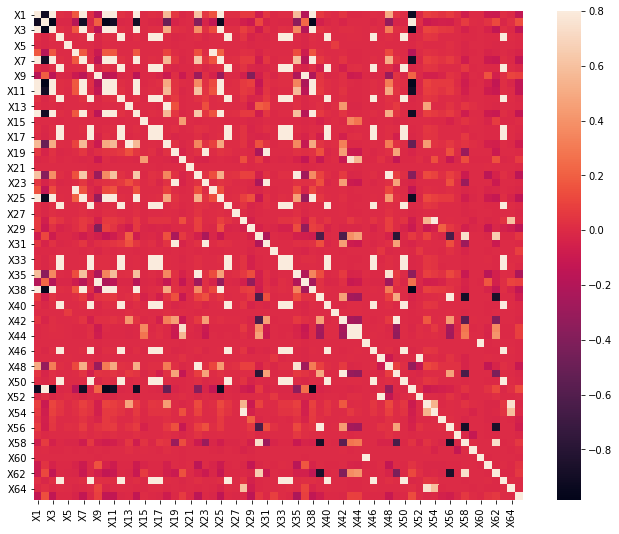

In [14]:
#Create heatmap
import seaborn as sns
corrma = train_data_eda.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrma, vmax=.8, square=True)
plt.show()

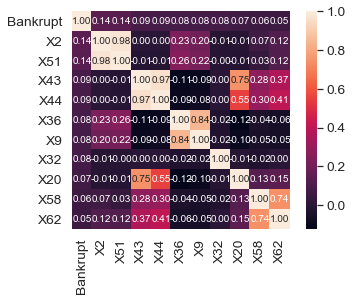

In [15]:
#Zoom the heatmap: find 10 features that have highest correlation with target
cols = corrma.nlargest(11, 'Bankrupt')['Bankrupt'].index
cm = np.corrcoef(train_data_eda[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Conclusion: From the heatmap, we could see that several pairs of features are highly correlated with each other such that I might use the PCA in transformation to remove the correlated features. Meanwhile, we could see that the features are weakly correlated with target, and X2, X43, X36, X32, X20, X58, X62 are the seven features that have highest correlation with target and no multicollinearity problem.

## Prepare the data and train the baseline model
Prepare the data
1. Clean the data 
 - Missing values: Impute data with KNNImputer which fills the missing values using values from k nearest neighbors
 - Imbalanced data: Oversample the minority using the SMOTE to create synthetic new examples from existing examples
2. Scaling: standardize the data. This step should be executed before the transformation since PCA only accepts zero centered features.
3. Transformation: Use PCA to reduce the correlated features and dimension. The cumulative explained variance is set at 95%.

Train the model
1. Select a model: First, we use Naive Bayes as baseline model
2. Fit the model
3. Validation & Cross Validation: 
 - In-sample: accuracy score, cross validation
 - Out-of-sample: accuracy, precision, recall scores

In [16]:
#Make the pipeline
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline 

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
smote = SMOTE(random_state = 42)
scaler = StandardScaler()
pca = PCA(n_components = 0.95,svd_solver = 'full')
naiveb = GaussianNB()
baseline_model = Pipeline(steps = [('KNNImputer',knn_imputer),('SMOTE',smote),('scaler',scaler),('PCA',pca),('GaussianNB',naiveb)])

In [17]:
#Fit the pipeline
_ = baseline_model.fit(x_train,y_train)

#In-sample accuracy
from sklearn.metrics import accuracy_score
score_in_sample = None
name = "Naive Bayes"
y_train_predict = baseline_model.predict(x_train)
score_in_sample = accuracy_score(y_train,y_train_predict)

print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

Model: Naive Bayes in sample score=0.09



In [18]:
#Cross validation score
from sklearn.model_selection import cross_val_score
cross_val_scores = None
cross_val_scores = cross_val_score(baseline_model,x_train,y_train,cv = 5)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: Naive Bayes avg cross validation score=0.11



In [19]:
#Out-of-sample score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
acc_score_out_sample = None
rec_score_out_sample = None
prec_score_out_sample = None
y_test_predict = baseline_model.predict(x_test)
acc_score_out_sample = accuracy_score(y_test, y_test_predict)
rec_score_out_sample = recall_score(y_test, y_test_predict, pos_label=1, average="binary")
prec_score_out_sample = precision_score(y_test, y_test_predict, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=acc_score_out_sample,
                                                                            r=rec_score_out_sample,
                                                                            p=prec_score_out_sample
                                                                            )
         )

	Naive Bayes Accuracy: 9.2%, Recall 100.0%, Precision 6.0%


Conclusion: we could see that the scores for Naive Bayes model are quite low. That's probably because Naive Bayes model is too simple to solve this classification problem. Therefore, we could only use it as baseline model and try other models for improvement.

## Prepare data, train sophisticated models and analyze error

Prepare the data (similar as baseline model)

1. Clean the data (KNNImputer, SMOTE)
2. Scaling (standardscaler)
3. Transformation (PCA + Kernel for SVM, PCA for other models)

Train the model

1. Select a model: Logistic, RandomForest, SVM
2. Fit the model
3. Performance:
  - Out-of-sample: accuracy, precision, recall scores
  
Erorr analysis

Models could be improved and compared by making and evaluating the trade-off between Recall and Precision. Here I assume that it is 5 times worse to fail to identify a company that will go bankrupt (False Negative) than it is to fail to identify a company that won't go bankrupt (False Positive) which means FN:FP = 1:5.
1. Use precision-recall curve to find models' thresholds that satisfy the trade-off I make, since the trade-off depends on the ratio FN to FP.
2. Use AUC score to compare the models, which computes the area under the ROC curve. Model has better precision-recall trade-off, if it has higher AUC score.

Get conlusion at the end of 6.4


In [20]:
#Prepare the model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
logistic_clf = LogisticRegression(solver ='lbfgs')
forest_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability = True, gamma="auto")
clf_list = [logistic_clf,forest_clf,svm_clf]

In [21]:
#Prepare the data, train models and error analysis
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
i = 0
accu_list = []
prec_list = []
reca_list = []
roc_auc_list = []
#Use minmaxscaler to avoid reaching the limit
mmscaler = MinMaxScaler()
for clf in clf_list:
#Fit the pipeline i.e. prepare the data and train models  
#Since random forest is not sensitive to multicollinearity and it can handle the imbalanced data
    if clf == forest_clf:
        soph_model = Pipeline(steps = [('KNNImputer',knn_imputer),('mmscaler',mmscaler),('Classify',clf)])
    else:
        soph_model = Pipeline(steps = [('KNNImputer',knn_imputer),('SMOTE',smote),('scaler',scaler),('PCA',pca),('Classify',clf)])
    _ = soph_model.fit(x_train,y_train)
#Make trade-off to improve models
#Predict probabilities
    y_test_pos = soph_model.predict_proba(x_test)[:,1]       
#Get precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_pos)
#Get the optimal threshold that satisfies our assumption: FN:FP = 1:5
    for j in range(len(thresholds)):
        if (1/recall[j]-1)/(1/precision[j]-1)<=1/5:
            thres = thresholds[j]
        else:
            break
#Get the performance for each model
    y_predict_test_soph = [1 if y_prob > thres else 0 for y_prob in y_test_pos]
    accu_list.append( "{:3.1%}".format(accuracy_score(y_test,y_predict_test_soph)))
    prec_list.append("{:3.1%}".format(precision_score(y_test,y_predict_test_soph,pos_label=1, average="binary")))
    reca_list.append("{:3.1%}".format(recall_score(y_test,y_predict_test_soph,pos_label=1, average="binary")))
    roc_auc_list.append("{:3.1%}".format(roc_auc_score(y_test,y_predict_test_soph)))
    i = i+1
#Create the dataframe
name = ['Logistic','RandomForest','SVM']
index_df = ['Accuracy Score','Precision Score','Recall Score','AUC Score']
df = pd.DataFrame(data = np.array([accu_list,prec_list,reca_list,roc_auc_list]),index = index_df,columns = name)
df
    

/Users/evyzheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Logistic,RandomForest,SVM
Accuracy Score,86.2%,91.4%,86.2%
Precision Score,23.6%,38.2%,23.6%
Recall Score,60.7%,75.0%,60.7%
AUC Score,74.3%,83.7%,74.3%


Conclusion: From the above dataframe, we can see that random forest classifier has highest accuracy score (91.4%), recall score (75%) and AUC score (83.7%) which means it is the most suitable model for this problem among three models. Therefore, I choose the random forest classifier as the model to predict whether a company will go bankrupt in the following year. 

## Fine Tuning

Use GridSearchCV to find the optimal hyper-parameters for random forest classifier. Since the number of hyper-parameters in random forest classifier is large, I choose to tune the most important hyper-parameters.

After doing the grid search, we get the optimal hyper-parameters for the random forest. n_estimators = 700, max_features = 'auto', max_depth = 10, min_samples_split = 5

In [22]:
#Improved model after fine tuning
ranforest = RandomForestClassifier(random_state = 42, n_estimators = 700, max_features = 'auto', max_depth = 10, min_samples_split = 5)
final_model_pipeline = Pipeline(steps = [('KNNImputer',knn_imputer),('mmscaler',mmscaler),('Random',ranforest)])
_ = final_model_pipeline.fit(x_train,y_train)
y_test_pos_ran = final_model_pipeline.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test,y_test_pos_ran)
for j in range(len(thresholds)):
        if (1/recall[j]-1)/(1/precision[j]-1)<=1/5:
            thres_ran = thresholds[j]
        else:
            break
y_predict_test_ran = [1 if y_prob > thres_ran else 0 for y_prob in y_test_pos_ran]
acc_score_out_sample = accuracy_score(y_test,y_predict_test_ran)
rec_score_out_sample = recall_score(y_test,y_predict_test_ran,pos_label=1, average="binary")
prec_score_out_sample = precision_score(y_test,y_predict_test_ran,pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m="Random Forest",
                                                                            a=acc_score_out_sample,
                                                                            r=rec_score_out_sample,
                                                                            p=prec_score_out_sample
                                                                            )
         )

	Random Forest Accuracy: 92.7%, Recall 78.6%, Precision 43.1%


Conclusion: After fine tuning, the model is improved. The out-of-sample accuracy score increases from 91.4% to 92.7%. The precision score increases from 38.2% to 43.1%. Meanwhile, the recall score also increases from 75% to 78.6%.

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [23]:

import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    #Turn string to numeric
    cols = X.columns
    X[cols] = X[cols].apply(pd.to_numeric,errors='coerce')
    #Drop ID and X37
    X = X.drop(columns=["X37","Id"])
    #Use final model pipeline
    y_predict = final_model_pipeline.predict_proba(X)[:,1]
    predictions = [1 if y_prob > thres_ran else 0 for y_prob in y_predict]
    return predictions



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

The following cell
- Assumes that you have created `X_test, y_test` as your proxy for an out of sample dataset
    - It serves the same function as `X_hold`, the holdout dataset, but you have the associated target (only the instructors have `y_hold`)

In [24]:
print("Done")

Done
